In [152]:
##################################################
#Developed by: Mohsen Zaker Esteghamati (revised on 10/10/2024)
#Email: mohsen.zaker@usu.edu

#This is part of the code used to train RF and SVM models to predict shear wall drift capacit in the following paper:

#    Zaker Esteghamati, M., Bean, B., Burton, H., Naser, M.Z. (2024) Beyond development: Challenges in deploying machine 
#    learning models for structural engineering applications, Journal of Structural Engineering

#if you use any part of this code, please cite the above mentioned reference. 
##################################################

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn import metrics
import shap

In [2]:
#reading the database for shear 
Inventory = pd.read_excel('210611 Shear Wall Drift Capacity Dataset.xlsx',sheet_name='Sheet2')
Inventory=Inventory.dropna()

In [137]:
#displaying database to ensure everything is OK. 
Inventory

,lambda_b,v _sqr_fc\n,Load_Ratio,Aprov_Areq,s_db,ρ_long_BE,ρ_t_web,c_lw,hx_b,lbe_lw,fu_fy,Ultimate_drift
0,86.614173,3.6,9.55,1.46,4.02,3.44,0.27,21.65,0.669291,0.162402,1.200345,1.67
1,101.181102,4.8,12.98,1.30,4.02,3.44,0.27,25.30,0.669291,0.162402,1.200345,1.60
2,102.493438,4.4,10.05,1.28,3.50,1.54,0.27,25.62,0.748031,0.189633,1.516949,1.40
3,91.338583,4.3,11.72,1.78,4.02,3.44,0.27,22.83,0.669291,0.162402,1.630670,1.10
4,62.829380,5.0,2.76,0.97,2.62,2.44,0.62,27.78,0.618421,0.257218,1.448747,2.16
...,...,...,...,...,...,...,...,...,...,...,...,...
159,8.175000,13.9,19.17,0.74,2.35,6.13,2.62,32.70,0.250000,0.138000,1.393805,2.49
160,8.550000,11.8,21.00,0.98,2.50,2.26,2.03,34.20,0.370000,0.185000,1.452174,2.86
161,8.150000,12.6,21.01,0.92,3.33,2.26,1.01,32.60,0.370000,0.185000,1.452174,2.56
162,0.178335,8.4,0.00,1.44,7.01,3.82,0.71,4.08,0.140044,0.046597,1.588764,2.31


In [3]:
#######################################################
# Defining input variables and responses
########################################################
FeaturesNames=["$\lambda_b$","$v_{max}/\sqrt{f'_c}$","$P/f'_cA_g$","$A_{sh,pr/req}$","$s/d_b$",r"$\rho_{l,BE}$",r"$\rho_{t,w}$","$c/l_w$","$h_x/b$","$l_{BE}/l_w$","$f_u/f_y$"]
Y= Inventory[['Ultimate_drift']].values
#getting All Feature Names
ColHead=list(Inventory.columns.values)
IdxFeature=list(range(11))
FeaturesList= list(ColHead[i] for i in IdxFeature)
# Getting Feature values
X = Inventory[FeaturesList].values

In [ ]:
#######################################################
# Plotting features to see how they look like
########################################################
p = sns.pairplot(X,height=1.5,corner=True, grid_kws={"despine": False}, diag_kws=dict(color='b', fill=False, kde=True),plot_kws=dict(marker="o", facecolor='w', edgecolor='k', linewidth=1))
sns.set_context("notebook", font_scale=2)
plt.savefig('Statistics.pdf',format='pdf', dpi=1800)

In [38]:
########################################################
#splitting data to train surrogates models
########################################################
from sklearn.model_selection import train_test_split
rows_num=range(len(Inventory.index))
X_train, X_test,Y_train, Y_test, indices_train,indices_test = train_test_split(X,Y, rows_num, test_size = 0.3)
#normalizing data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#scaling features
scalerX = MinMaxScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)
scalerY = StandardScaler()
#Just to be consistent!
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)
#scaling Y for SVM and XGboost!
Y_trainSC=scalerY.fit_transform(Y_train)
Y_testSC=scalerY.transform(Y_test)

In [46]:
########################################################
#saving partitioned data fore reuse
########################################################
#pd.DataFrame(indices_train).to_csv("index_train2.csv",index=None)
#pd.DataFrame(indices_test).to_csv("index_test2.csv",index=None)

In [6]:
########################################################
#Plotting testing and training and calculating accuracy metrics
########################################################

def ResultPlot(y_train,y_test,y_pred_train,y_pred_test, FileName,marker,color ):
    #this is just a plotting function that compare testing and training
    f = plt.figure(figsize=(4, 4))
    ax1 = f.add_subplot(111)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rc('font', family='Times New Roman', weight='normal', size=16)
    ax1.scatter(y_train, y_pred_train, marker='o', facecolor = color,alpha=0.5,edgecolor=color, label='Train')
    ax1.scatter(y_test, y_pred_test, marker=marker, facecolors='k', edgecolor='k', label='Test')
    ax1.set_xticks([0,2.5,5])
    ax1.set_yticks([0,2.5,5])
    ax1.set_xlim([0 ,5])
    ax1.set_ylim([0 ,5])
    ax1.set_xlabel('Observed drift (%)', family='Times New Roman', weight='normal', size=18)
    ax1.set_ylabel('Predicted drift (%)', family='Times New Roman', weight='normal', size=18)
    ax1.minorticks_on()
    ax1.grid(b=True, which='major', color='k', linestyle="-", linewidth=0.5, alpha=0.5)
    ax1.grid(b=True, which='minor', color='k', linestyle="--", linewidth=0.5, alpha=0.3)
    diag_line1, = ax1.plot([0,130], [0,130], ls="-",color = 'k', linewidth=1.0)
    leg = plt.legend(loc='lower right')
    leg.get_frame().set_edgecolor('k')
    plt.savefig(FileName,format='pdf', dpi=1800,bbox_inches="tight")
    plt.show()
    
########################################################
#Model accuracy summary
#focus on adjusted R2, RMSE, MAE
########################################################

def CrossValSummary(X_train,X_test,y_train,y_test,y_pred_train,y_pred_test,reg,p):  
    print('----------Model Summary------------')
    print('R-squared of regressor on training set: {:.2f}'
     .format(1-(1-(reg.score(X_train, y_train)))*(len(X_train)-1)/(len(X_train)-p-1)))
    print('R-squared of regressor on test set: {:.2f}'
     .format(1-(1-(reg.score(X_test, y_test)))*(len(X_test)-1)/(len(X_test)-p-1)))
    print('RMSE of regressor on train set: {:.10f}'
     .format(np.sqrt(metrics.mean_squared_error(y_train,y_pred_train))))
    print('RMSE of regressor on test set: {:.10f}'
     .format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_test))))
    print('MAE of regressor on train set: {:.10f}'
     .format(np.sqrt(mae(y_train,y_pred_train))))
    print('MAE of regressor on test set: {:.10f}'
     .format(np.sqrt(mae(y_test,y_pred_test))))


In [189]:
#################################
#performign Randomized search to hypertune RF models!
#################################
from sklearn.ensemble import RandomForestRegressor
IdxX=list([0,4,8,9])

##################################
#use grid search to tune hyperparameters of RF!
#Please note that the features were selected using a different code based on RFE algorithms (not part of this notebook)
#################################
parameters_for_testing = {
    
     'n_estimators':[int(x) for x in np.arange(155,165,1)],
     'max_depth':[int(x) for x in np.arange(155,165,1)], 
     'min_samples_split':[int(x) for x in np.arange(5,8,1)],

}

                    
RF_model = RandomForestRegressor()
gs = GridSearchCV(estimator = RF_model, param_grid = parameters_for_testing, n_jobs=5,cv=2, verbose=10,scoring='neg_mean_squared_error')
gs.fit(X_train[:,IdxX],Y_train)
print('best params')
print (gs.best_params_)

#################################
#Random forest model fitting
#################################
regressorForest = RandomForestRegressor(n_estimators = gs.best_params_['n_estimators'],
                                        max_depth=gs.best_params_['max_depth'], min_samples_split=gs.best_params_['min_samples_split'])
regressorForest.fit(X_train[:,IdxX], Y_train)
#prediction
y_train_predForest=regressorForest.predict(X_train[:,IdxX])
y_test_predForest=regressorForest.predict(X_test[:,IdxX])
#plotting results
#plotting results
ResultPlot(Y_train,Y_test,y_train_predForest,y_test_predForest,'RF.pdf','.','r')
CrossValSummary(X_train[:,IdxX],X_test[:,IdxX],Y_train,Y_test,y_train_predForest,y_test_predForest,regressorForest,len(IdxX))

Best Score: -0.37313290786136266
Best Hyperparameters: {'n_estimators': 161, 'min_samples_split': 7, 'max_depth': 161}


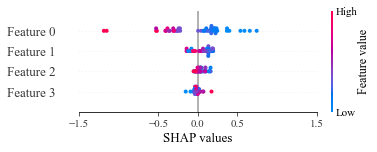

In [191]:
######################################
# doing shapely analysis
######################################3
explainer = shap.TreeExplainer(regressorForest)
shap_RF = explainer.shap_values(X_test[:,IdxX])
shap.summary_plot(shap_RF, X_test[:,IdxX],show=False)
w, _ = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(w*0.7, w*0.3)
fig, ax = plt.gcf(), plt.gca()
ax.set_xticks([-1.5,-0.5 ,0,0.5,1.5], size=18)
ax.set_xlabel('SHAP values')
plt.tight_layout()
plt.savefig("Shap_summary_RF.pdf",format='pdf', dpi=1800,bbox_inches="tight")
plt.show()

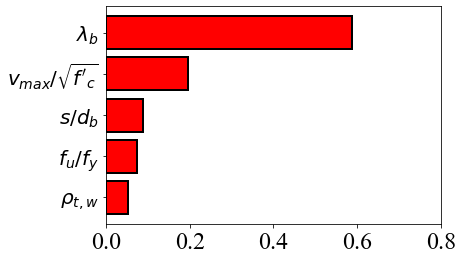

In [12]:
Names= list(FeaturesNames[i] for i in IdxX)
importanceFac = regressorForest.feature_importances_
indices = np.argsort(importanceFac)
plt.barh(range(len(indices)), importanceFac[indices], color='r' ,edgecolor='k', linewidth=2,align='center')
plt.yticks(range(len(indices)), [Names[i] for i in indices], fontsize=20)
plt.xticks([0,0.2,0.4,0.6,0.8],fontsize=24)
plt.savefig('RF_importance.pdf',format='pdf', dpi=1800,bbox_inches="tight")
plt.show()

Fitting 3 folds for each of 200 candidates, totalling 600 fits
best params
{'C': 1.0, 'gamma': 3.01, 'kernel': 'rbf'}


The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


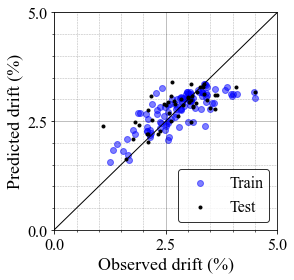

----------Model Summary------------
R-squared of regressor on training set: 0.55
R-squared of regressor on test set: 0.44
RMSE of regressor on train set: 0.4257456075
RMSE of regressor on test set: 0.4682931693
Mean R2 on training is 0.18 with a std of 0.33
Mean R2 on test is -0.63 with a std of 1.59
MAE of regressor on train set: 0.5533248911
MAE of regressor on test set: 0.5839234601


In [147]:
##################################
#Training SVM model
#################################

IdxX=[0,7,9,10]
from sklearn.svm import SVR
##################################
#use grid search to tune hyperparameters of SVM!
#Please note that the features were selected using a different code based on RFE algorithms (not part of this notebook)
#################################
parameters_for_testing = {
     'gamma'           : [i/100 for i in range(1,500,50)],
     'C'               : [i/10 for i in range(10,1000,50)],
     'kernel'           : ['rbf'], 
}
                   
SVR_model = SVR()
gs = GridSearchCV(estimator = SVR_model, param_grid = parameters_for_testing, n_jobs=5,cv=3, verbose=10,scoring='neg_mean_squared_error')
gs.fit(X_train[:,IdxX],Y_trainSC.ravel())
print('best params')
print (gs.best_params_)
##################################################
#fitting SVR
##################################################
from sklearn.svm import SVR
regressorSVR=SVR(C=gs.best_params_['C'], kernel='rbf',gamma=gs.best_params_['gamma'])
regressorSVR.fit(X_train[:,IdxX],Y_trainSC.ravel())
##prediction
y_train_predSVR=regressorSVR.predict(X_train[:,IdxX])
y_train_predSVR=scalerY.inverse_transform(y_train_predSVR.reshape(-1,1))
y_test_predSVR=regressorSVR.predict(X_test[:,IdxX])
y_test_predSVR=scalerY.inverse_transform(y_test_predSVR.reshape(-1,1))
##################################################
#model summary
##################################################
ResultPlot(Y_train,Y_test,y_train_predSVR,y_test_predSVR,'SVR.pdf','.','b')

X has feature names, but MinMaxScaler was fitted without feature names


  0%|          | 0/47 [00:00<?, ?it/s]

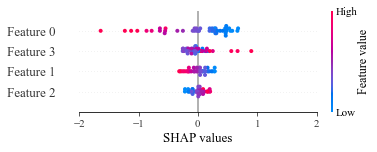

In [151]:
######################################
# doing shapely analysis
######################################3
X_shap = scalerX.transform(Inventory[FeaturesList])
X_shap = pd.DataFrame(X_shap, columns = FeaturesList)
shap_SVR = shap.KernelExplainer(regressorSVR.predict,X_test[:,IdxX])
shap_SVR_values = shap_SVR.shap_values(X_test[:,IdxX])
shap.summary_plot(shap_SVR_values, X_test[:,IdxX],show=False)
w, _ = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(w*0.7, w*0.3)
fig, ax = plt.gcf(), plt.gca()
ax.set_xticks([-2,-1 ,0,1,2], size=18)
ax.set_xlabel('SHAP values')
plt.tight_layout()
plt.savefig("Shap_summary_SVM.pdf",format='pdf', dpi=1800,bbox_inches="tight")
plt.show()

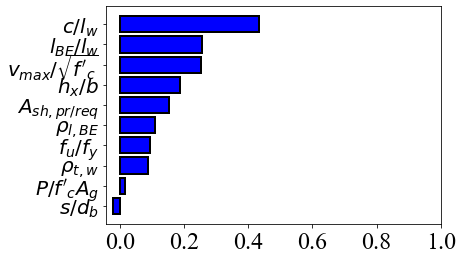

In [66]:
from sklearn.inspection import permutation_importance
Names= list(FeaturesNames[i] for i in IdxX)
perm_importance = permutation_importance(regressorSVR, X_test[:,IdxX], Y_testSC.ravel())
indices = perm_importance.importances_mean.argsort()
plt.barh(range(len(indices)), perm_importance.importances_mean[indices], color='b' ,edgecolor='k', linewidth=2,align='center')
plt.yticks(range(len(indices)), [Names[i] for i in indices], fontsize=20)
plt.xticks([0,0.2,0.4,0.6,0.8,1],fontsize=24)
plt.savefig('SVM_importance.pdf',format='pdf', dpi=1800,bbox_inches="tight")
plt.show()